# **LDA, word2vec, классификация документов**
### **Часть 1. Тематическое моделирование**
1. Обучение моделей LDA(с разным числом тем), выбор лучшей с
помощью когерентности(использовав претренированный word2vec), поиск соответствия между найденными темами и исходными тегами и
категориями с помощью word2vec.
2. Анализ результатов.

### **Часть 2. Классификация**
1. Классификация новостей по категориям, используя word2vec, doc2vec(попытаться как можно сильнее повысить точность).
2. Анализ результатов.

In [ ]:
import os
import numpy as np
import lxml
from lxml import objectify, etree, html
from xml.etree import ElementTree as xml
import urllib3
from io import StringIO, BytesIO
import pandas as pd
import re
import codecs
from pymystem3 import Mystem
import copy
import nltk
import string
nltk.download("stopwords")
from nltk.corpus import stopwords
import sklearn
import scipy
import random
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix, classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier
import itertools
import json
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk import word_tokenize
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
from tqdm import tqdm
from gensim.test.utils import common_texts
import pyLDAvis
import pyLDAvis.gensim
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Новостной корпус - https://www.bbc.com/news

## Чтение данных

Прочитаем все наши новости.

In [ ]:
files = ['output0.xml', 'output.xml','output2.xml','output3.xml', 'output4.xml', 'output5.xml', 'output6.xml']
catalog = []
for file in files:
    xmlstr = codecs.open(file, encoding='utf-8', mode='r').read()
    root = etree.fromstring(xmlstr)
    for element_lvl1 in root:
        article = {}
        for element_lvl2 in element_lvl1:
            txt = element_lvl2.text
            article[element_lvl2.tag] = '' if txt is None else txt
        catalog.append(article)

In [ ]:
len(catalog)

1787

Всего получилось 1787 текстов.

Обязательно перемешаем все статьи, т.к. некоторые категории могут идти подряд.

In [ ]:
random.shuffle(catalog)

In [ ]:
catalog [0:3]

[{'category': 'world',
  'title': 'Assam register: Four million risk losing India citizenship',
  'text': 'Media playback is unsupported on your device Media caption Living in limbo: Assam\'s four million unwanted\n\nIndia has published a list which effectively strips about four million people in the north-eastern state of Assam of their citizenship.\n\nThe National Register of Citizens (NRC) is a list of people who can prove they came to the state by 24 March 1971, a day before neighbouring Bangladesh declared independence.\n\nIndia says the process is needed to identify illegal Bangladeshi migrants.\n\nBut it has sparked fears of a witch hunt against Assam\'s ethnic minorities.\n\nFearing violence, officials say that no-one will face immediate deportation.\n\nThey say that a lengthy appeal process will be available to all - even if it means millions of families will live in limbo until they get a final decision on their legal status.\n\nWho is affected?\n\nMillions of people fled to 

## Preprocessing

Текст каждый статьи приводим к нижнему регистру, удаляем знаки препинаия, цифры, стоп-слова и нормализуем. Также мы расширили список стоп-слов теми словами, которые ссылаются на картинки или видео, присутствующие в статьях.

In [ ]:
def preprocess_article(text, mystem=Mystem(entire_input=False)):
    text = text.lower()
    en_stopwords = stopwords.words('english')
    stop = ['image', 'copyright', 'getty', 'images', 'caption', 'media', 'playback',
            'video', 'timewise', 'unsupported', 'afp', 'reuters']
    en_stopwords.extend(stop)
    dgts = [str(i) for i in range(10)]
    punct = string.punctuation + '£'
    for s in punct:
        text = text.replace(s, '')
    text = re.sub( '\s+', ' ', text).strip()
    
    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in en_stopwords\
              and token not in dgts\
              and token != " "]
    text = " ".join(tokens)
    return text

def preprocess_docs(catalog):
    preproc_catalog = copy.deepcopy(catalog)
    for i in range(len(preproc_catalog)):
        preproc_catalog[i]['text'] = preprocess_article(catalog[i]['text'])
    return preproc_catalog

In [ ]:
preproc_catalog = preprocess_docs(catalog)

In [ ]:
preproc_catalog[0:3]

[{'category': 'world',
  'title': 'Assam register: Four million risk losing India citizenship',
  'text': 'device living limbo assams four million unwanted india published list effectively strips four million people northeastern state assam citizenship national register citizens nrc list people prove came state march day neighbouring bangladesh declared independence india says process needed identify illegal bangladeshi migrants sparked fears witch hunt assams ethnic minorities fearing violence officials say noone face immediate deportation say lengthy appeal process available even means millions families live limbo get final decision legal status affected millions people fled neighbouring india bangladesh declared independent country pakistan march sparking bitter war many refugees settled assam assam accord agreement signed pm rajiv gandhi cannot prove came northeastern state march deleted electoral rolls expelled considered legitimate citizens million people submitted documents nrc 

In [ ]:
labels_w, tags, data = list(), list(), list()
for i in range(len(preproc_catalog)):
    labels_w.append(preproc_catalog[i]['category'])
    data.append(preproc_catalog[i]['text'])
    tags.append(preproc_catalog[i]['tags'])

Всего у нас 6 категорий. UK является отдельной категорией, это значит местные новости, потому что BBC - это новостной сайт Великобритании.

In [ ]:
categories = list(np.unique(labels_w))
categories

['business', 'health', 'sport', 'technology', 'uk', 'world']

# Часть 1. Тематическое моделирование

Токенезируем каждый текст.

In [ ]:
data_words = list()
for text in data:
    data_words.append(word_tokenize(text, language='english'))
len(data), len(data_words)

(1787, 1787)

Для моделей LDA нужен словарь из всех появляющихся в текстах слов и корпус, с частотой появления каждого конкретного слова в тексте. Создадим их. Корпус - отображение (word_id, word_frequency).

In [ ]:
# Dictionary
id2word = corpora.Dictionary(data_words)
# Term Document Frequency
corpus = [id2word.doc2bow(t) for t in data_words]
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 2),
 (7, 5),
 (8, 2),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 3),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 3),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 2),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 3),
 (52, 2),
 (53, 1),
 (54, 6),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 3),
 (62, 2),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 3),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 2),
 (75, 2),
 (76, 2),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 4),
 (82, 2),
 (83, 4),
 (84, 1),
 (85, 2),
 (86, 1),
 (87, 1),
 (88, 3),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 2),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 2),
 (99, 1),
 (100, 1),

In [ ]:
# Пример слова и его частоты для 1 текста
[(id2word[cp[0]], cp[1]) for cp in corpus[0]]

[('absence', 1),
 ('accepts', 1),
 ('according', 1),
 ('admit', 1),
 ('admits', 1),
 ('agencies', 2),
 ('ago', 2),
 ('also', 5),
 ('alwayson', 2),
 ('ambitious', 1),
 ('among', 1),
 ('another', 1),
 ('april', 1),
 ('arent', 1),
 ('arrangement', 1),
 ('asked', 1),
 ('attitudes', 1),
 ('basis', 1),
 ('become', 1),
 ('begin', 1),
 ('bickerstaffe', 3),
 ('big', 1),
 ('bit', 1),
 ('blames', 1),
 ('board', 1),
 ('boss', 1),
 ('bosses', 1),
 ('boundaries', 1),
 ('brought', 1),
 ('call', 1),
 ('came', 1),
 ('career', 1),
 ('careful', 1),
 ('carphone', 1),
 ('chair', 1),
 ('changing', 1),
 ('charity', 1),
 ('chief', 3),
 ('children', 1),
 ('cofounder', 1),
 ('colleagues', 1),
 ('come', 1),
 ('committed', 1),
 ('common', 1),
 ('communications', 1),
 ('company', 1),
 ('considered', 1),
 ('consultancy', 2),
 ('control', 1),
 ('could', 1),
 ('credited', 1),
 ('culture', 3),
 ('currently', 2),
 ('data', 1),
 ('days', 6),
 ('dealing', 1),
 ('decision', 1),
 ('depending', 1),
 ('determine', 1),
 ('det

In [ ]:
def get_coherence(lda_model):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_w2v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score: ', coherence_lda)

In [ ]:
def visualize(lda_model, file_name):
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(vis, file_name)

In [ ]:
def visualize2(lda_model):
    en_stopwords = stopwords.words('english')
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(stopwords=en_stopwords,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=10,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

## LDA models

Теперь построим LDA модели с разным количеством тем.

* ### Модель **1** (5 тем)

In [ ]:
lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=100, update_every=1, chunksize=100,
                                             passes=10, alpha='auto', per_word_topics=True)

Посмотрим на полученные темы.

In [ ]:
lda_model1.print_topics()

[(0,
  '0.012*"said" + 0.005*"government" + 0.005*"would" + 0.004*"also" + 0.004*"says" + 0.004*"new" + 0.003*"climate" + 0.003*"people" + 0.003*"uk" + 0.003*"mr"'),
 (1,
  '0.012*"coronavirus" + 0.011*"china" + 0.011*"virus" + 0.011*"said" + 0.008*"cases" + 0.008*"people" + 0.008*"health" + 0.007*"us" + 0.006*"chinese" + 0.005*"outbreak"'),
 (2,
  '0.009*"said" + 0.008*"mr" + 0.007*"us" + 0.005*"one" + 0.005*"president" + 0.004*"taliban" + 0.004*"women" + 0.004*"told" + 0.004*"would" + 0.004*"also"'),
 (3,
  '0.006*"league" + 0.006*"first" + 0.006*"one" + 0.005*"world" + 0.005*"game" + 0.005*"team" + 0.005*"time" + 0.004*"bbc" + 0.004*"last" + 0.004*"cup"'),
 (4,
  '0.012*"people" + 0.011*"said" + 0.006*"says" + 0.005*"one" + 0.004*"get" + 0.004*"would" + 0.004*"could" + 0.003*"like" + 0.003*"work" + 0.003*"time"')]

Вычислим когерентность.

In [ ]:
get_coherence(lda_model1)

Coherence Score:  0.5438507


Визуализируем темы и ключевые слова.

Чтобы посмотреть визуализацию мы предлагаем открыть соответствующий html файл :)

In [ ]:
visualize(lda_model1, 'lda_model1.html')

На левом графике видно, что 2 и 3 темы немного пересекаются. 5 тема распространена меньше других.

Выведем наиболее часто используемые слова в первых четырех темах, чтобы их обобщить и было нагляднее.

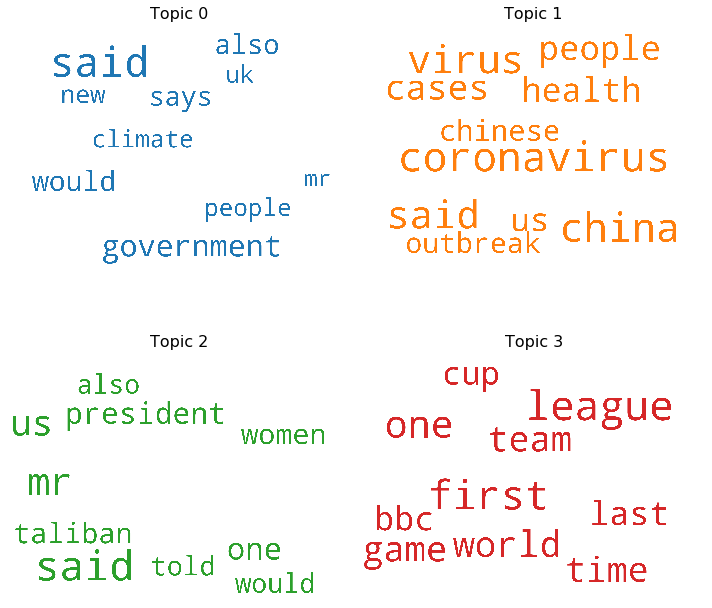

In [ ]:
visualize2(lda_model1)

* **Topic 0**: Исходя из слов government и uk, эта тема связана с внутренней политикой Британии, то есть в этой тему, возможно, попали темы из раздела "UK".
* **Topic 1**: Очевидно, это тема Здоровье.
* **Topic 2**: Политика.
* **Topic 3**: Спорт.

* ### Модель **2** (10 тем)

In [ ]:
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=100, update_every=1, chunksize=100,
                                             passes=10, alpha='auto', per_word_topics=True)

In [ ]:
lda_model2.print_topics()

[(0,
  '0.008*"said" + 0.008*"people" + 0.006*"climate" + 0.005*"world" + 0.005*"one" + 0.005*"also" + 0.005*"around" + 0.004*"police" + 0.004*"change" + 0.004*"fire"'),
 (1,
  '0.010*"south" + 0.010*"country" + 0.008*"city" + 0.008*"africa" + 0.008*"north" + 0.008*"china" + 0.007*"korea" + 0.006*"iran" + 0.006*"african" + 0.005*"church"'),
 (2,
  '0.017*"said" + 0.008*"people" + 0.007*"one" + 0.007*"told" + 0.006*"would" + 0.006*"says" + 0.006*"women" + 0.006*"time" + 0.005*"could" + 0.004*"also"'),
 (3,
  '0.007*"first" + 0.007*"league" + 0.006*"one" + 0.006*"team" + 0.005*"time" + 0.005*"world" + 0.005*"last" + 0.005*"game" + 0.005*"bbc" + 0.005*"cup"'),
 (4,
  '0.013*"said" + 0.009*"water" + 0.009*"wales" + 0.009*"people" + 0.008*"school" + 0.007*"schools" + 0.007*"hong" + 0.006*"river" + 0.005*"pupils" + 0.005*"kong"'),
 (5,
  '0.025*"mr" + 0.014*"president" + 0.010*"trump" + 0.008*"biden" + 0.008*"us" + 0.007*"democratic" + 0.007*"sanders" + 0.007*"vote" + 0.007*"political" + 0.0

In [ ]:
get_coherence(lda_model2)

Coherence Score:  0.60708535


Когерентность возросла.

In [ ]:
visualize(lda_model2, 'lda_model2.html')

Появилось больше пересекающихся тем, но все темы довольно распространённые, 1- самая распространённая.

* ### Модель **3** (20 тем)

In [ ]:
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=20, random_state=100, update_every=1, chunksize=100,
                                             passes=10, alpha='auto', per_word_topics=True)

In [ ]:
lda_model3.print_topics()

[(0,
  '0.015*"facebook" + 0.014*"twitter" + 0.012*"information" + 0.011*"social" + 0.009*"said" + 0.009*"online" + 0.009*"recognition" + 0.009*"news" + 0.008*"users" + 0.008*"false"'),
 (1,
  '0.025*"coronavirus" + 0.024*"virus" + 0.018*"cases" + 0.016*"said" + 0.016*"china" + 0.015*"people" + 0.015*"health" + 0.012*"outbreak" + 0.011*"italy" + 0.011*"spread"'),
 (2,
  '0.025*"said" + 0.011*"told" + 0.009*"people" + 0.009*"one" + 0.008*"women" + 0.007*"would" + 0.007*"time" + 0.006*"made" + 0.005*"like" + 0.005*"life"'),
 (3,
  '0.014*"first" + 0.013*"one" + 0.012*"world" + 0.012*"time" + 0.011*"last" + 0.008*"two" + 0.008*"team" + 0.007*"could" + 0.007*"best" + 0.007*"well"'),
 (4,
  '0.020*"nhs" + 0.017*"symptoms" + 0.014*"disease" + 0.013*"advice" + 0.013*"patients" + 0.011*"uk" + 0.011*"people" + 0.010*"risk" + 0.010*"hands" + 0.008*"school"'),
 (5,
  '0.038*"mr" + 0.026*"president" + 0.021*"trump" + 0.015*"biden" + 0.015*"democratic" + 0.014*"sanders" + 0.014*"vote" + 0.013*"stat

In [ ]:
get_coherence(lda_model3)

Coherence Score:  0.6629831


In [ ]:
visualize(lda_model3, 'lda_model3.html')

Появилось больше перекрытий между темами. 20 тему можно вообще исключить, ей принадлежат единицы документов.

* ### Модель **4** (30 тем)

In [ ]:
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=30, random_state=100, update_every=1, chunksize=100,
                                             passes=10, alpha='auto', per_word_topics=True)

In [ ]:
lda_model4.print_topics()

[(28,
  '0.097*"sidewalk" + 0.085*"toronto" + 0.073*"labs" + 0.053*"waterfront" + 0.043*"city" + 0.020*"labss" + 0.016*"urban" + 0.015*"development" + 0.015*"neighbourhood" + 0.014*"site"'),
 (15,
  '0.026*"venture" + 0.014*"beauty" + 0.012*"firm" + 0.012*"capital" + 0.012*"minds" + 0.011*"investment" + 0.011*"business" + 0.010*"largescale" + 0.010*"backing" + 0.007*"brand"'),
 (17,
  '0.056*"board" + 0.052*"animal" + 0.039*"boards" + 0.029*"san" + 0.026*"unit" + 0.017*"francisco" + 0.016*"whilst" + 0.016*"plant" + 0.012*"ring" + 0.010*"wet"'),
 (13,
  '0.059*"year" + 0.056*"cancer" + 0.050*"bbc" + 0.049*"usa" + 0.044*"bowel" + 0.042*"footballer" + 0.031*"full" + 0.030*"netherlands" + 0.028*"award" + 0.028*"megan"'),
 (9,
  '0.029*"wild" + 0.023*"driver" + 0.020*"crash" + 0.019*"huang" + 0.015*"illegal" + 0.015*"indonesia" + 0.015*"indonesian" + 0.014*"ban" + 0.014*"tesla" + 0.011*"vegas"'),
 (7,
  '0.039*"rates" + 0.031*"brain" + 0.024*"jones" + 0.023*"falls" + 0.022*"spanish" + 0.020

In [ ]:
get_coherence(lda_model4)

Coherence Score:  0.6881668


In [ ]:
visualize(lda_model4, 'lda_model4.html')

Большое число тем сильно пересекается. Темы 3,4 почти полностью совпадают. Появляется много маленьких кругов(мало распространенных тем).

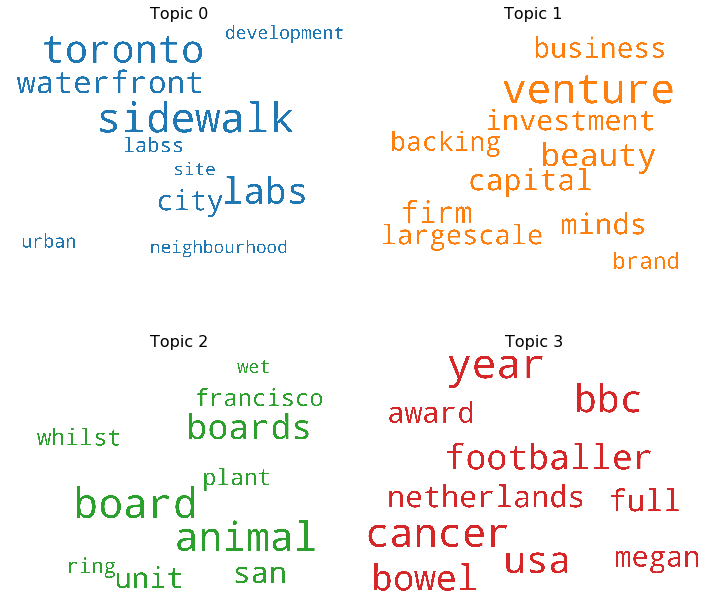

In [ ]:
visualize2(lda_model4)

Аналогично первой модели мы интерпретируем темы и для четвевртой.

* **Topic 0**: Тут вырисовывается Экология.
* **Topic 1**: Бизнес.
* **Topic 2**: Тут всё не так однозначно: ключевые слова "животное", "растение", "влажность". Скорее всего, здесь что-то связанное с Природой.
* **Topic 3**: Спорт.

*После анализа облака слов у двух моделей (первой и четвертой) мы заметили, что было бы неплохо добавить слова глаголы "said", "told" в список стоп-слов.*

**Best model:** Если посмотреть на Coherence Score полученных моделей, то лучше **МОДЕЛЬ 4 с 30 темами**.

Чем больше число тем, тем выше когерентность. Однако большое количество тем не всегда хорошо, т.к. многие из них могут сильно пересекаться. Модель со слишком большим количеством тем, как правило, имеет много перекрытий, круги небольшого размера, сгруппированные в одной области диаграммы.

Согласно значению когерентности, чаще всего топ-слова встречаются в одном и том же контексте в модели 4, где у нас наибольшее количество тем. Но с другой стороны, мы понимаем, что в данной модели может происходить путаница в темах из-за их обилия. И этот факт подтверждает визуализация, в которой можно заметить, что в этом случае темы 1, 2, 3, 4, 6 и 8 сильно пересекаются и находятся в одной области графика, но все-таки стоит отметить, что все темы распределены по всей плоскости. А в модели 1 темы так же распределены по всей плоскости и в то же время лишь две из них пересекаются. Именно благодаря этому модель 1 выглядит более выигрышной, если учитывать визуализацию.

Далее будем работать с этими двумя моделями.

* ### Модель 4

Теперь найдём информацию о том, какая тема преобладает в каждом новостном тексте(документе).

In [ ]:
def documents_topic(lda_model):
    df = pd.DataFrame()
    for i, doc in enumerate(lda_model[corpus]):
        doc = sorted(doc[0], key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0:  # main topic
                wp = lda_model.show_topic(topic_num)
                keywords = [word for word, prop in wp]
                df = df.append(pd.Series([int(topic_num), round(prop_topic,4), keywords]), ignore_index=True)
            else:
                break
    texts = pd.Series(data)
    df = pd.concat([df, texts], axis=1)
    df = df.reset_index()
    df.columns = ['Document №', 'MainTopic', 'PercContribution', 'Keywords', 'Text']
    '''PercContibution-Percentage Contribution'''
    return df

В таблице представлен номер документа, его преобладющая тема, доля этой темы(наибольшая среди всех), ключевые слова данной темы и текст самого документа.

In [ ]:
df = documents_topic(lda_model4)
df.head(10)

,Document №,MainTopic,PercContribution,Keywords,Text
0,0,12.0,0.1867,"[money, company, people, said, one, year, prod...",marc nohr marc nohr parttime boss means spend ...
1,1,24.0,0.5514,"[people, health, coronavirus, uk, symptoms, co...",common type gut bacterium may increase persons...
2,2,2.0,0.2379,"[said, police, told, people, mr, including, fo...",device dropped dead sky hundreds birds found d...
3,3,9.0,0.7875,"[wild, driver, crash, huang, illegal, indonesi...",driver tesla model x died shortly crash apple ...
4,4,25.0,0.6629,"[said, water, river, station, city, public, el...",facebook thomas hughes previously worked human...
5,5,12.0,0.2980,"[money, company, people, said, one, year, prod...",tesco uks biggest retailer tesco stocking plas...
6,6,20.0,0.3035,"[one, years, two, says, first, many, could, wo...",half flights taken last year yearold men stag ...
7,7,27.0,0.8094,"[said, government, mr, would, minister, uk, pr...",apples chief executive tim cook said company w...
8,8,19.0,0.5357,"[court, trial, case, salazar, told, said, coul...",salazar centre alongside farah right american ...
9,9,12.0,0.7219,"[money, company, people, said, one, year, prod...",florist zhao yuanyuan wearing protective face ...


Также найдём число документов, принадлежащей каждой теме и посчитаем распределение тем по документам.

In [ ]:
counts = df['MainTopic'].value_counts()
contribution = round(counts/counts.sum(), 4)
df_all_topics = pd.concat([counts, contribution], axis=1)
df_all_topics = df_all_topics.reset_index()
df_all_topics.columns = ['MainTopic', 'NumberDocuments', 'PercDocuments']
df_all_topics = df_all_topics.sort_values(by=['MainTopic'])
df_all_topics.reset_index(drop=True)

,MainTopic,NumberDocuments,PercDocuments
0,0.0,30,0.0168
1,1.0,112,0.0627
2,2.0,150,0.0839
3,3.0,26,0.0145
4,4.0,17,0.0095
5,5.0,53,0.0297
6,6.0,13,0.0073
7,8.0,31,0.0173
8,9.0,8,0.0045
9,10.0,73,0.0409


Можно заметить, что нет нескольких тем: 7, 13, 17 (считая от 0). Т.е. они не являются доминирующими ни в одном из документов. Самая распространённая тема-20 (считая от 0), ей принадлежит 472 текста.

* ### Модель 1

Построим те же таблицы для 1 модели.

In [ ]:
df2 = documents_topic(lda_model1)
df2.head(10)

,Document №,MainTopic,PercContribution,Keywords,Text
0,0,4.0,0.5585,"[people, said, says, one, get, would, could, l...",marc nohr marc nohr parttime boss means spend ...
1,1,4.0,0.9688,"[people, said, says, one, get, would, could, l...",common type gut bacterium may increase persons...
2,2,4.0,0.5583,"[people, said, says, one, get, would, could, l...",device dropped dead sky hundreds birds found d...
3,3,0.0,0.9820,"[said, government, would, also, says, new, cli...",driver tesla model x died shortly crash apple ...
4,4,0.0,0.9966,"[said, government, would, also, says, new, cli...",facebook thomas hughes previously worked human...
5,5,4.0,0.5053,"[people, said, says, one, get, would, could, l...",tesco uks biggest retailer tesco stocking plas...
6,6,1.0,0.5241,"[coronavirus, china, virus, said, cases, peopl...",half flights taken last year yearold men stag ...
7,7,1.0,0.5044,"[coronavirus, china, virus, said, cases, peopl...",apples chief executive tim cook said company w...
8,8,2.0,0.6399,"[said, mr, us, one, president, taliban, women,...",salazar centre alongside farah right american ...
9,9,1.0,0.9960,"[coronavirus, china, virus, said, cases, peopl...",florist zhao yuanyuan wearing protective face ...


In [ ]:
counts2 = df2['MainTopic'].value_counts()
contribution2 = round(counts2/counts2.sum(), 4)
df_all_topics2 = pd.concat([counts2, contribution2], axis=1)
df_all_topics2 = df_all_topics2.reset_index()
df_all_topics2.columns = ['MainTopic', 'NumberDocuments', 'PercDocuments']
df_all_topics2 = df_all_topics2.sort_values(by=['MainTopic'])
df_all_topics2.reset_index(drop=True)

,MainTopic,NumberDocuments,PercDocuments
0,0.0,477,0.2669
1,1.0,306,0.1712
2,2.0,320,0.1791
3,3.0,318,0.1780
4,4.0,366,0.2048


Самая распространённая тема - 1. Вообще распределение по темам примерно одинаковое.

## Word2Vec соответствие

Рассмотрим несколько документов и посчитаем близость темы с категорией и тегами.

* #### Документ 1

In [ ]:
preproc_catalog[3]

{'category': 'technology',
 'title': "Tesla Autopilot crash driver 'was playing video game'",
 'text': 'driver tesla model x died shortly crash apple employee died tesla car hit concrete barrier playing game time crash investigators believe us national transportation safety board ntsb said car driving semiautonomously using teslas autopilot software tesla instructs drivers keep hands wheel autopilot mode ntsb said crashes foreseeable tesla implement changes autopilot system authority published results twoyear investigation following crash march teslas autopilot software steered vehicle triangular gore area motorway intersection accelerated concrete barrier tesla entered gore area highway hit barrier front tesla separated rear causing two drivers crash tesla driver walter huang taken hospital died injuries drivers survived ntsb said tesla driver taken control car distracted smartphone game teslas collision avoidance system designed detect crash barrier teslas autopilot system provide ef

In [ ]:
df[3:4]

,Document №,MainTopic,PercContribution,Keywords,Text
3,3,9.0,0.7875,"[wild, driver, crash, huang, illegal, indonesi...",driver tesla model x died shortly crash apple ...


In [ ]:
lda_model4.print_topic(9)

'0.029*"wild" + 0.023*"driver" + 0.020*"crash" + 0.019*"huang" + 0.015*"illegal" + 0.015*"indonesia" + 0.015*"indonesian" + 0.014*"ban" + 0.014*"tesla" + 0.011*"vegas"'

Загрузим предобученную на Google news модель Word2Vec.

In [ ]:
vectorizerW2V = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

Найдём **сходство между найденной темой и категорией** документа(считается как среднее между близостью каждого слова темы и самой категорией).

In [ ]:
def similarity(model, category, words=list()):
    s = 0
    for w in words:
        s+= model.similarity(w,category)
        #print(model.similarity(w,category))
    print('Similarity: ', round(s/len(words),4))

In [ ]:
similarity(vectorizerW2V, labels_w[3], df['Keywords'][3])

Similarity:  0.065


По такому маленькому значению можно сказать, что ничего общего между категорией и темой нет.

Например, посмотрим на сходство кошки и собаки.

In [ ]:
vectorizerW2V.similarity('cat','dog')

0.76094574

Теперь найдём **сходство между темой и каждым тегом**.

In [ ]:
similarity(vectorizerW2V, 'driverless_cars', df['Keywords'][3])

Similarity:  0.0674


In [ ]:
similarity(vectorizerW2V, 'apple', df['Keywords'][3])

Similarity:  0.1108


In [ ]:
similarity(vectorizerW2V, 'tesla', df['Keywords'][3])

Similarity:  0.1426


Близость маленькая для всех тегов.

* #### Документ 2

In [ ]:
preproc_catalog[0]

{'category': 'business',
 'title': 'The people who got to the top on a four-day week',
 'text': 'marc nohr marc nohr parttime boss means spend time family charity work one million people senior managerlevel jobs work part time number growing according official figures mr nohr group chief executive agencies miroma runs group marketing communications agencies started working four days week two years ago found hours become unsustainable admits everyone board decision noting phrase parttimer considered mean slacker careful depending speaking people come era presenteeism thats world brought require quite bit mental leap alwayson culture using data office national statistics consultancy promotes flexible working found number parttime workers senior level positions last year since used fulltime equivalent salary year determine qualified senior managerlevel employee consultancy credited changing attitudes towards flexible working shift years ago people reluctant admit worked parttime fear seen

In [ ]:
df[0:1]

,Document №,MainTopic,PercContribution,Keywords,Text
0,0,12.0,0.1867,"[money, company, people, said, one, year, prod...",marc nohr marc nohr parttime boss means spend ...


In [ ]:
lda_model4.print_topic(12)

'0.009*"money" + 0.008*"company" + 0.008*"people" + 0.008*"said" + 0.008*"one" + 0.008*"year" + 0.008*"products" + 0.007*"also" + 0.007*"new" + 0.006*"online"'

**Сходство категория-тема:**

In [ ]:
similarity(vectorizerW2V, labels_w[0], df['Keywords'][0])

Similarity:  0.2243


В этом документе сходство уже больше, но всё равно в целом небольшое.

**Сходство теги-тема:**

Слова gig нет в словаре, поэтому вместо тега 'gig_economy', оставим 'economy'.

In [ ]:
similarity(vectorizerW2V, 'economy', df['Keywords'][0])

Similarity:  0.1256


In [ ]:
similarity(vectorizerW2V, 'employment', df['Keywords'][0])

Similarity:  0.1273


Близость тегов и темы также маленькая.

## Вывод

Соответствие между темой документа, его категорией и тегами получилось не очень хорошее, хотя когерентность для 4 модели нормальная. Возможно стоит ещё обновить список стоп-слов, чтобы темы образовались более точными, т.е. в состав тем вошли наиболее четко определяющие схожие документы слова.

# Часть 2. Классификация

## Подготовка данных

Переведём категории для будущих классификаторов в числовой формат.

In [ ]:
labels = [categories.index(lb) for lb in labels_w]

## Word2Vec

Векторизируем наши данные с помощью Word2Vec.

In [ ]:
def averageEmb(tokens_list, w2v_model, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    vectors = [w2v_model[word] if word in w2v_model else np.zeros(k) for word in tokens_list]
    summed = np.sum(vectors, axis=0)
    return np.divide(summed, len(vectors))

def getW2Vembeddings(w2v_model, data):
    embeddings = [averageEmb(x, w2v_model) for x in data]
    return embeddings

In [ ]:
embeddings = getW2Vembeddings(vectorizerW2V, data_words)

## Разделение на train/test

Соотношение обучающей и тестовой выборок - 70% к 30%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3, random_state=42)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

print(len(X_train), len(y_train), len(X_test), len(y_test))

1250 1250 537 537


Посмотрим сколько текстов каждой категории взято в набор train. И сверимся с его размером.

In [ ]:
for c in np.unique(np.asarray(y_train)):
    print('Class \'{}\' samples N: {}'.format(c, np.asarray(y_train)[np.asarray(y_train) == c].shape[0]))

Class '0' samples N: 175
Class '1' samples N: 58
Class '2' samples N: 214
Class '3' samples N: 140
Class '4' samples N: 232
Class '5' samples N: 431


## Build Models

Попробуем классификаторы, которые в прошлой лабораторной показали лучшие результаты.

* **SVM**
* **Random Forest**
* **MLP** (Multi-layer Perceptron classifier)
* **One-Vs-The-Rest**

### Define classifiers:

In [ ]:
predictor_svm = LinearSVC().fit(X_train, y_train)

In [ ]:
predictor_rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [ ]:
predictor_mlp = MLPClassifier(alpha=1, max_iter=1000).fit(X_train, y_train)

In [ ]:
predictor_oneVSall = OneVsRestClassifier(LinearSVC(), n_jobs=-1).fit(X_train, y_train)

### Evaluate Classifiers:

In [ ]:
y_pred_svm = predictor_svm.predict(X_test)
print('SVM accuracy: {}%'.format(round(np.mean(y_test == y_pred_svm), 2)))

SVM accuracy: 0.88%


Попытаемся улучшить точность, подобрав параметры.

In [ ]:
param_grid = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'svc__gamma' : [0.01, 0.1, 1]}
svm_gs = GridSearchCV(make_pipeline(MinMaxScaler(), SVC(kernel='rbf')),
                      param_grid, n_jobs=-1)
svmg_gs = svm_gs.fit(X_train, y_train)

In [ ]:
svm_gs.best_params_

{'svc__C': 10, 'svc__gamma': 0.1}

In [ ]:
svm_gs.best_score_

0.9216000000000001

Построим новый классификатор SVM с лучшими параметрами.

In [ ]:
predictor_svm2 = make_pipeline(MinMaxScaler(), SVC(kernel='rbf', C=10, gamma=0.1)).fit(X_train, y_train)
y_pred_svm2 = predictor_svm2.predict(X_test)
print('SVM accuracy: {}%'.format(round(np.mean(y_test == y_pred_svm2), 2)))

SVM accuracy: 0.91%


Точность стала выше.

In [ ]:
y_pred_rf = predictor_rf.predict(X_test)
print('RF accuracy: {}%'.format(round(np.mean(y_test == y_pred_rf), 2)))

RF accuracy: 0.9%


Попытаемся улучшить точность, подобрав параметры.

In [ ]:
distr = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [10, 20, 40, 50],
    'max_features': ["auto", "sqrt", "log2", None]
}
rf_gs = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), n_iter=100, 
                           param_distributions=distr, n_jobs=-1)

In [ ]:
rf_gs = rf_gs.fit(X_train, y_train)

In [ ]:
rf_gs.best_params_

{'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 40}

In [ ]:
rf_gs.best_score_

0.8976000000000001

Построим новый классификатор RandomForest с лучшими параметрами.

In [ ]:
predictor_rf2 = RandomForestClassifier(n_estimators=500, max_depth=40, max_features="sqrt").fit(X_train, y_train)
y_pred_rf2 = predictor_rf2.predict(X_test)
print('RF accuracy: {}%'.format(round(np.mean(y_test == y_pred_rf2), 2)))

RF accuracy: 0.89%


Точность не увеличилась.

In [ ]:
y_pred_mlp = predictor_mlp.predict(X_test)
print('MLP accuracy: {}%'.format(round(np.mean(y_test == y_pred_mlp), 2)))

MLP accuracy: 0.82%


In [ ]:
y_pred_onevsall = predictor_oneVSall.predict(X_test)
print('One-VS-all accuracy: {}%'.format(round(np.mean(y_test == y_pred_onevsall), 2)))

One-VS-all accuracy: 0.88%


Лучшая модель - **SVM**, c точностью предсказания **91%**.

### Confusion Matrices

Теперь для 3 классификаторов, с наибольшей точностью, построим нормализированную confusion matrix, чтобы посмотреть соотношение правильно и не правильно предсказанных категорий (какие категории путаются между собой).

In [ ]:
def ConfMatr(classifier, name_pr):
    title = name_pr + ' Confusion Matrix'
    fig, ax = plt.subplots(figsize=(15,15))
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=categories,
                                     cmap=plt.cm.BuPu,
                                     normalize='true',
                                    xticks_rotation='vertical',
                                    ax=ax)
    disp.ax_.set_title(title)

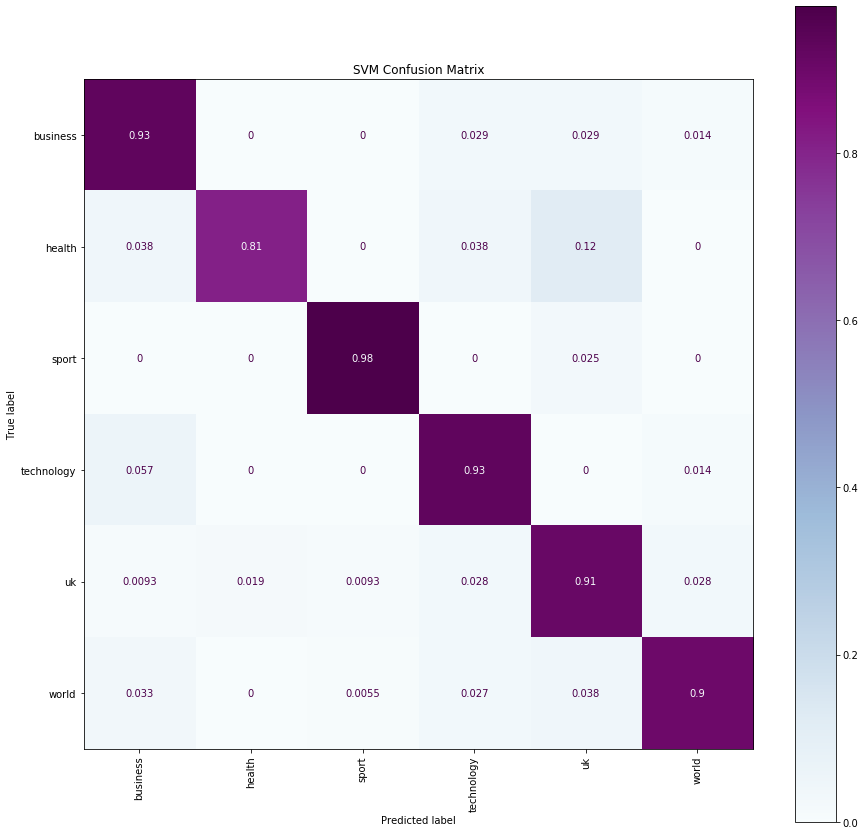

In [ ]:
ConfMatr(predictor_svm2, 'SVM')

Категория health имеет меньше всего правильных предсказаний, она путается в 12% случаев с категорией uk.

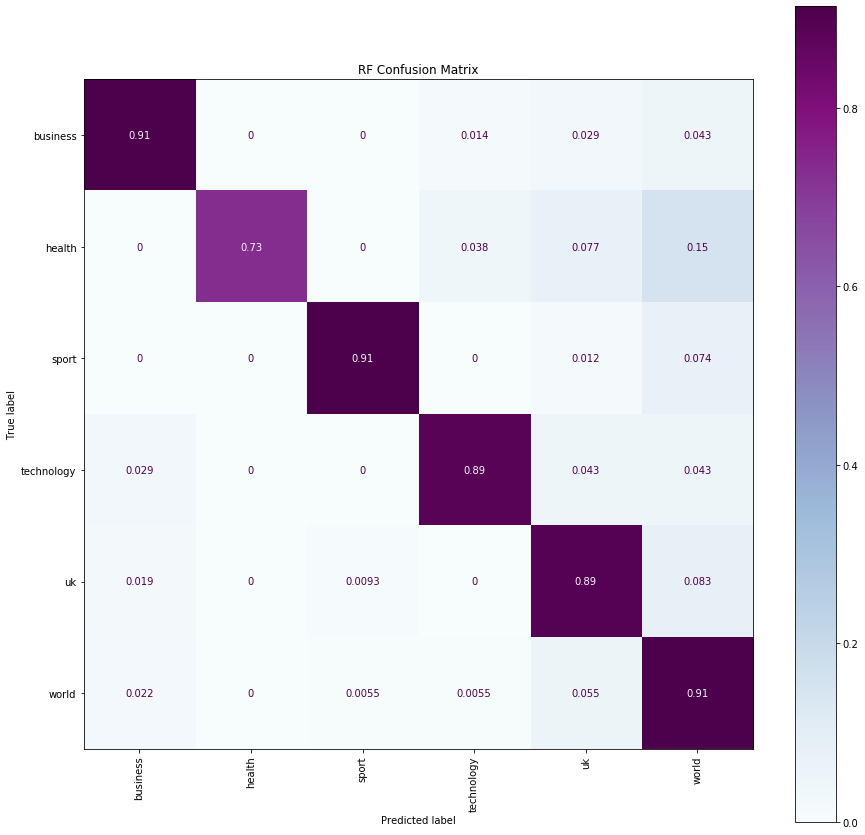

In [ ]:
ConfMatr(predictor_rf, 'RF')

Больше всего путается категория health с категорией world, что вполне естественно, учитывая текущую ситуацию в мире, связанную с вспышкой вируса.

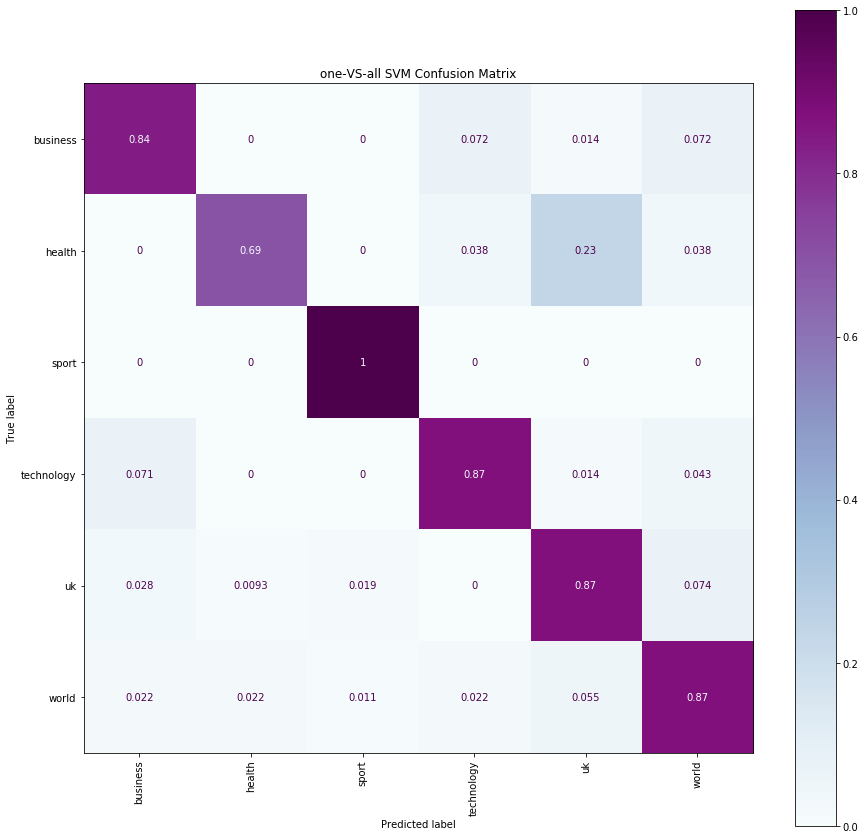

In [ ]:
ConfMatr(predictor_oneVSall, 'one-VS-all SVM')

Категория sport определяется абсолютно точно. Категория health имеет меньше всего правильных предсказаний.

### Feature Importances:

Теперь попробуем выявить наиболее важные признаки на основе лесов из деревьев.

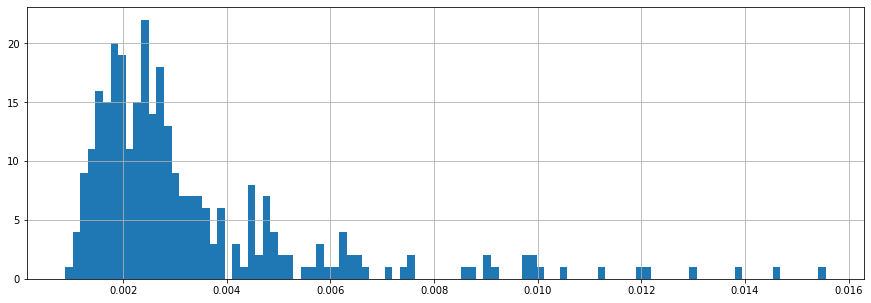

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(predictor_rf.feature_importances_, bins=100)
plt.grid(True)

Частота не всегда убывает, а скачет, наиболее информативные признаки идут вперемешку.

### Create feature selector:

Попробуем отобрать 1000 признаков и посмотреть улучшится ли результат.

In [ ]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=1000)).fit(X_train, y_train)
X_train_transformed = feature_selector.transform(X_train)
X_test_transformed = feature_selector.transform(X_test)
print(X_train_transformed.shape, X_test_transformed.shape)

(1250, 88) (537, 88)


In [ ]:
predictor_svm_ = make_pipeline(MinMaxScaler(), SVC(kernel='rbf', C=10, gamma=0.1)).fit(X_train_transformed, y_train)
y_pred_svm_ = predictor_svm_.predict(X_test_transformed)
print('SVM accuracy: {}%'.format(round(np.mean(y_test == y_pred_svm_), 2)))

SVM accuracy: 0.85%


Точность уменьшилась, т.к. важные признаки всё таки смешаны.

### Metrics

Посчитаем разные метрики для лучшего классификатора.

In [ ]:
def get_metrics(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    print("Precision = %.2f, Recall = %.2f, F1 = %.2f" % (precision, recall, f1))

In [ ]:
get_metrics(y_test, y_pred_svm2)

Precision = 0.92, Recall = 0.91, F1 = 0.91


Классификатору можно доверять и его полнота 91%.

##  Doc2Vec

#### Подготовим данные.

In [ ]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

Пометим каждый текст своей категорией.

In [ ]:
train_documents=[]
test_documents=[]
for i in range(len(preproc_catalog)):
    if i<1250:
        train_documents.append(TaggedDocument(words=tokenize_text(preproc_catalog[i]['text']), tags=[preproc_catalog[i]['category']]))
for i in range(len(preproc_catalog)):
    if i>=1250:
        test_documents.append( TaggedDocument(words=tokenize_text(preproc_catalog[i]['text']), tags=[preproc_catalog[i]['category']]))

In [ ]:
train_documents[0]

TaggedDocument(words=['device', 'living', 'limbo', 'assams', 'four', 'million', 'unwanted', 'india', 'published', 'list', 'effectively', 'strips', 'four', 'million', 'people', 'northeastern', 'state', 'assam', 'citizenship', 'national', 'register', 'citizens', 'nrc', 'list', 'people', 'prove', 'came', 'state', 'march', 'day', 'neighbouring', 'bangladesh', 'declared', 'independence', 'india', 'says', 'process', 'needed', 'identify', 'illegal', 'bangladeshi', 'migrants', 'sparked', 'fears', 'witch', 'hunt', 'assams', 'ethnic', 'minorities', 'fearing', 'violence', 'officials', 'say', 'noone', 'face', 'immediate', 'deportation', 'say', 'lengthy', 'appeal', 'process', 'available', 'even', 'means', 'millions', 'families', 'live', 'limbo', 'get', 'final', 'decision', 'legal', 'status', 'affected', 'millions', 'people', 'fled', 'neighbouring', 'india', 'bangladesh', 'declared', 'independent', 'country', 'pakistan', 'march', 'sparking', 'bitter', 'war', 'many', 'refugees', 'settled', 'assam', '

In [ ]:
test_documents[0]

TaggedDocument(words=['motheroftwo', 'among', 'britons', 'quarantined', 'coronavirushit', 'hotel', 'tenerife', 'says', 'family', 'feel', 'unsafe', 'left', 'rooms', 'lara', 'pennington', 'staying', 'lockeddown', 'costa', 'adeje', 'palace', 'hotel', 'two', 'young', 'children', 'elderly', 'parentsinlaw', 'says', 'put', 'risk', 'leave', 'rooms', 'believes', 'quarantine', 'rules', 'enforced', 'followed', 'guests'], tags=['world'])

#### Обучим Doc2Vec модель.

In [ ]:
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores, alpha=0.025, min_alpha=0.001)
model_dbow.build_vocab([x for x in tqdm(train_documents)])
train_documents  = utils.shuffle(train_documents)
model_dbow.train(train_documents,total_examples=len(train_documents), epochs=30)

100%|██████████████████████████████████████████████████████████████████████████| 1250/1250 [00:00<00:00, 771011.76it/s]


In [ ]:
def vector_for_learning(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, feature_vectors
model_dbow.save('./Model.d2v')

#### Получим train и test выборки.

In [ ]:
y_train, X_train = vector_for_learning(model_dbow, train_documents)
y_test, X_test = vector_for_learning(model_dbow, test_documents)

### Классификация

Опробуем те же модели классификации на данных, векторизованных с помощью Doc2Vec.

In [ ]:
predict_rf = RandomForestClassifier(n_estimators=500, max_depth=40, max_features="sqrt").fit(X_train, y_train)
y_pred_rf = predict_rf.predict(X_test)
print('RF accuracy: {}'.format(round(np.mean(y_test == y_pred_rf), 2)))

RF accuracy: 0.9


In [ ]:
predict_svm = LinearSVC().fit(X_train, y_train)
y_pred = predict_svm.predict(X_test)
print('SVM accuracy: {}'.format(round(np.mean(y_test == y_pred), 2)))

SVM accuracy: 0.91


In [ ]:
predict_mlp = MLPClassifier(alpha=1, max_iter=1000).fit(X_train, y_train)
y_pred_mlp = predict_mlp.predict(X_test)
print('MLP accuracy: {}'.format(round(np.mean(y_test == y_pred_mlp), 2)))

MLP accuracy: 0.92


In [ ]:
predict_oneVSall = OneVsRestClassifier(LinearSVC(), n_jobs=-1).fit(X_train, y_train)
y_pred_onevsall = predict_oneVSall.predict(X_test)
print('One-VS-all accuracy: {}'.format(round(np.mean(y_test == y_pred_onevsall), 2)))

One-VS-all accuracy: 0.91


Удалось повысить прошлую лучшую точность до **92%**, с помощью **MLP** классификатора.

#### Построим confusion matrixes

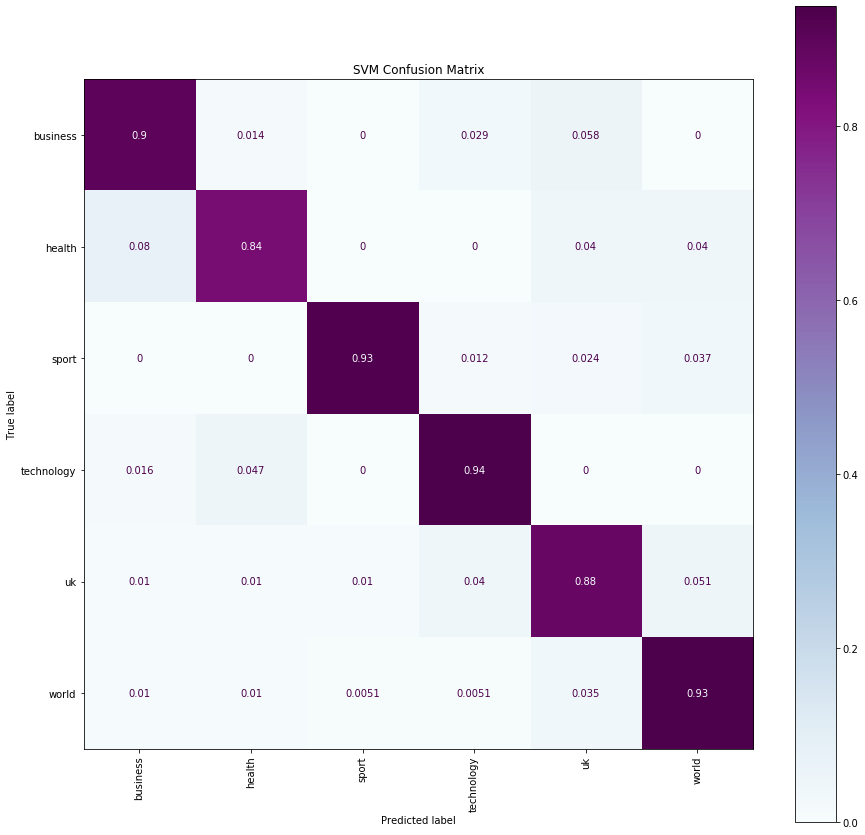

In [ ]:
ConfMatr(predict_svm, 'SVM')

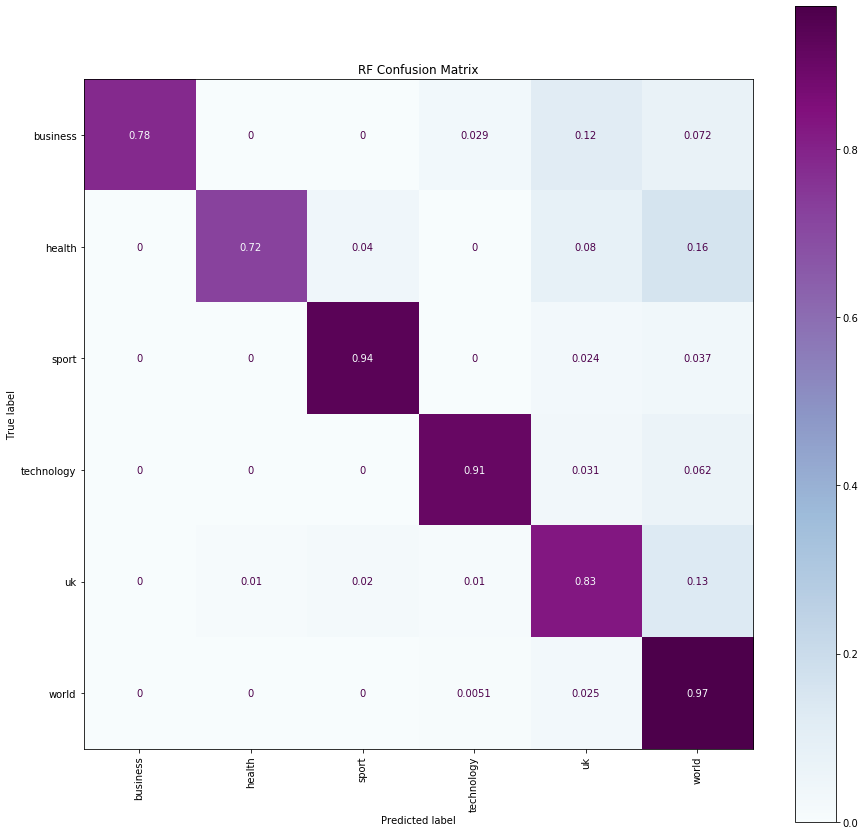

In [ ]:
ConfMatr(predict_rf, 'RF')

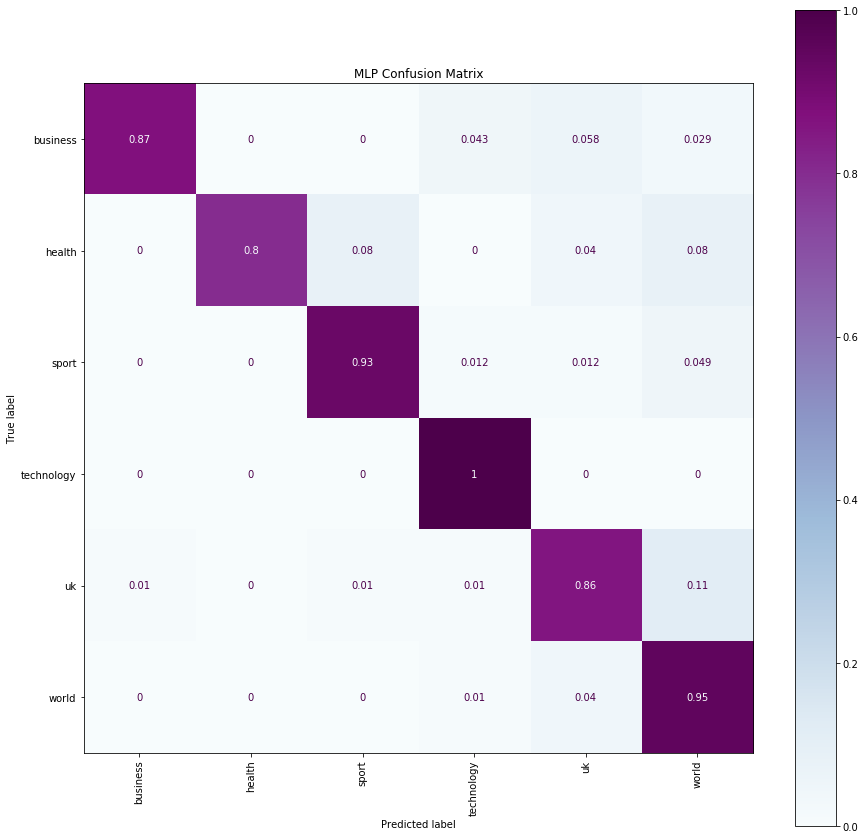

In [ ]:
ConfMatr(predict_mlp, 'MLP')

Три модели, для которых были построены матрицы ошибок, верно классифицировали почти все темы.

## Вывод

С помощью модели векторизации слов - Word2Vec, удалось увеличить точность предсказаний классификатора, по сравнению с предыдущей лабораторной работой. Конечно размер датасета ещё увеличился. Лучшая точность составила в этом случае 91%. А, используя Doc2Vec, точность удалось увеличить до 92%.